## Première approche ##

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/08/predict-stock-prices-using-RNN-part-1.html#normalization

In [ ]:
!pip install yfinance
!pip install mpld3
!pip install pytorchtools
!pip install torchvision
!pip install chart_studio

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 

cf.go_offline()

## Stock DATASET

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn import LSTM, Module, Dropout, ModuleList
from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math


In [ ]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data) - self.nb_samples

    def __getitem__(self, index, overlapping=True) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        if overlapping:
          sample = self.data['Close'][index:index+self.nb_samples+2]
        else:
          sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

In [ ]:
VISUALIZE_DATASET = False
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print("len dataset =", len(dataset))

## Modèle

In [ ]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True,  proj_size=1)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]
    

## Configuration

In [ ]:
class StockAIConfig():
    config = {
        "model":{
            "input_size": 1,
            "lstm_size": 128,
            "num_layers": 1,
            "keep_prob": 0.8
        },

        "dataset_train":{
            "start_date": '1950-01-03',
            "end_date": '2022-01-31',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":False
        },
        "dataset_test":{
            "start_date": '2008-11-17',
            "end_date": '2021-11-16',
            "interval_date": '1d',
            "nb_samples":15,
            "batch_size": 64,
            "shuffle":False
        },

        "learning":{
            "num_steps": 30,
            "init_lr": 1e-03,
            "lr_decay": 0.99,
            "init_epoch": 5,
            "max_epoch": 50
        }   
    }

##Prediction : Train / Test

In [ ]:
# Model config
config = StockAIConfig().config

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the dataset_train
dataset_train = StockPriceDataset(config["dataset_train"]["start_date"], 
                            config["dataset_train"]["end_date"],
                            config["dataset_train"]["interval_date"], 
                            config["dataset_train"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of the dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

# Init of the dataset_test
dataset_test = StockPriceDataset(config["dataset_test"]["start_date"], 
                            config["dataset_test"]["end_date"],
                            config["dataset_test"]["interval_date"], 
                            config["dataset_test"]["nb_samples"],
                            transform=normalize_by_last_unknown_price)

# Init dataloader of dataset_test
dataloader_test = DataLoader(dataset_test, config["dataset_test"]["batch_size"], config["dataset_test"]["shuffle"], drop_last=True)

# Init of the model
model = StockAI(config["model"]["input_size"],
                config["model"]["lstm_size"],
                config["model"]["num_layers"],
                config["model"]["keep_prob"])

model.to(device)

# Learning rate to use along the epochs
learning_rates = [config["learning"]["init_lr"] * (config["learning"]["lr_decay"] ** max(float(i + 1 - config["learning"]["init_epoch"]), 0.0)) for i in range(config["learning"]["max_epoch"])]

# Loss
loss_fn = MSELoss()
optimizer = RMSprop(model.parameters(), lr=learning_rates[0], eps=1e-08)

# to track the training loss as the model trains
train_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19999999999999996 and num_layers=1



In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Training loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=3, delta=0.00001, verbose=False)

In [ ]:
# Learning
losses = []
for epoch in range(config["learning"]["max_epoch"]):
    lr = learning_rates[epoch]
    print(f"Running for epoch {epoch}...")
    running_loss = 0.0

    ######################    
    #  train the model   #
    ######################
    for i_batch, batch in enumerate(dataloader_train):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = torch.squeeze(model.forward(x))
        loss = loss_fn(y_pred, y)
        train_losses.append(loss.item())

        if i_batch%100==0:
            print(f"step: {i_batch}, loss = {loss}")

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # ######################    
    # # validate the model #
    # ######################
    # model.eval() # prep model for evaluation
    # for x,y in enumerate(dataloader_valid):
    #     # forward pass: compute predicted outputs by passing inputs to the model
    #     output = model.forward(x)
    #     # calculate the loss
    #     loss = loss_fn(x, y)
    #     # record validation loss
    #     valid_losses.append(loss.item())

    # print training/validation statistics --> calculate average loss over an epoch
    train_loss = np.average(train_losses)
    # valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    # avg_valid_losses.append(valid_loss)
      
    # clear lists to track next epoch
    train_losses = []
    # valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(train_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Running for epoch 0...
step: 0, loss = 1.0433824062347412
step: 100, loss = 0.0009335804497823119
step: 200, loss = 0.0010907677933573723
Running for epoch 1...
step: 0, loss = 0.0004562341782730073
step: 100, loss = 0.0014651746023446321
step: 200, loss = 0.0009068081271834671
Running for epoch 2...
step: 0, loss = 0.00042536744149401784
step: 100, loss = 0.0013220286928117275
step: 200, loss = 0.0008259846945293248
Running for epoch 3...
step: 0, loss = 0.00038241600850597024
step: 100, loss = 0.0012111308751627803
step: 200, loss = 0.000749040103983134
Running for epoch 4...
step: 0, loss = 0.00036260628257878125
step: 100, loss = 0.0011237583821639419
step: 200, loss = 0.0006789112230762839
Running for epoch 5...
step: 0, loss = 0.00034626669366844
step: 100, loss = 0.0010499064810574055
step: 200, loss = 0.0006132602575235069
Running for epoch 6...
step: 0, loss = 0.0003397600376047194
step: 100, loss = 0.000989929074421525
step: 200, loss = 0.0005536305252462626
Running for epoch

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-2.4.2.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
# Test pour prédire la valeur de demain du S&P500
nb_samples = 15
x = dataset_train.data['Close'][-16:-1]
mean_value = np.mean(x)
last_value = x[-1]
norm_value = x[0]
print("last 15 values of S&P500 : ", x)
x = x/norm_value
x = torch.unsqueeze(torch.unsqueeze(torch.Tensor(x), 0), -1)

# 31/12/21
y_pred = model.forward(x)
x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))
x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()

print("predicted value : y_pred = ", y_pred.item())
print("predicted value = ", y_pred.item()*mean_value)


In [ ]:
df = pd.DataFrame({
    "epochs": np.arange(epoch),
    "training_loss": np.array(avg_train_losses)[1:] # Remove the first value because outlier
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='epochs', y=['training_loss'], color=['white'], 
         theme='solar', mode='lines', title='Training_loss across epochs')
plt.show()

In [ ]:
#test
runnning_mape = 0
for i_batch, batch in enumerate(dataloader_test):
        x, y = batch
        x = torch.unsqueeze(x, -1).float()
        y = y.float()
        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x)
        error = torch.mean(torch.abs((y - y_pred) / y))
        runnning_mape += error

mape = runnning_mape / len(dataloader_test)
print("mean absolute error percentage = ", mape.item()*100, "%")

mean absolute error percentage =  3.4854721277952194 %


In [ ]:
# Predict one following sample, taking the nb_samples last real values of S&P500
nb_test = len(dataset_test)
print("longueur du dataset test = ", nb_test)
y_truth_norm = []
y_truth = []
y_hat_norm = []
y_hat = []

for i in range(nb_test):
  x, y = dataset_test.__getitem__(i)
  # print("x = ", x)
  # print("y = ", y)
  norm_value = dataset_test.get_normalization_value(i)
  x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  # print("x = ", x)
  x = x.to(device)
  y_pred = model.forward(x)

  y_truth_norm.append(torch.Tensor.cpu(y).detach().numpy())
  y_truth.append(torch.Tensor.cpu(y).detach().numpy()*norm_value)
  y_hat_norm.append(torch.Tensor.cpu(y).detach().numpy())
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach().numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)),
    "real_value_norm": y_truth_norm, 
    "real_value": y_truth,
    "predicted_value_norm":y_hat_norm,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='sample_id', y=['real_value_norm','predicted_value_norm'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (normalized values)', size=10)

df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data (real values)', size=10)

plt.show()

longueur du dataset test =  3257


In [ ]:
# Métriques sur les résultats de prédiction


In [ ]:
# # Predict one following sample, taking the nb_samples last real values or lastly predicted values of S&P500
nb_test = len(dataset_test)
nb_samples = config["dataset_test"]["nb_samples"]
print("longueur du dataset test = ", nb_test)
y_truth = []
y_hat = []
x, y = dataset_test.__getitem__(0)
x, y = x.to(device), y.to(device)

for i in range(nb_test):

  _, y = dataset_test.__getitem__(i)

  # Normalization value for the current batch, needed to reproduce real value
  norm_value = dataset_test.get_normalization_value(i)
  x = torch.unsqueeze(torch.unsqueeze(x, 0), -1).float()
  x = x.to(device)

  # model computations + prediction
  y_pred = model.forward(x)

  # Ajout du y_pred à la fin du tenseur x et retrait de sa première valeur pour incrémenter d'une période temporelle
  x = torch.cat((torch.squeeze(x)[1:nb_samples], y_pred.reshape(1)))

  y_truth.append(torch.Tensor.cpu(y).detach().numpy()*norm_value)
  y_hat.append(float(torch.Tensor.cpu(y_pred).detach().numpy())*norm_value)

df = pd.DataFrame({
    "sample_id":np.arange(len(dataset_test)),
    "real_value":y_truth,
    "predicted_value":y_hat
    })

configure_plotly_browser_state()
df.iplot(kind='line', x='sample_id', y=['real_value','predicted_value'], color=['white', 'gold'], 
         theme='solar', mode='lines', title='Test data')
plt.show()

longueur du dataset test =  3257


# Ajout d'une deuxième méthode de prédiction : pluralité des stocks prédits #

Cette méthode est présentée ici : https://lilianweng.github.io/lil-log/2017/07/22/predict-stock-prices-using-RNN-part-2.html

In [ ]:
import urllib
from bs4 import BeautifulSoup
from urllib.parse import quote 
from datetime import datetime

Schéma du réseau mis en place :

## 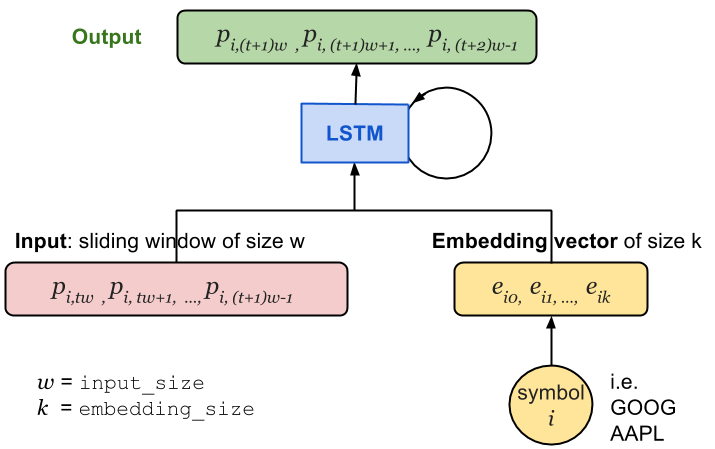

In [ ]:
class StockAI_with_embedding(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True,  proj_size=1)
    
    def forward(self,x):
        a, b = self.lstm(x)
        return b[0]

In [ ]:
from typing import List
class StockPriceDataset2(Dataset):
    def __init__(self, list_of_stocks: List=["GOOG"], start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_files: List=None):

        # If a local data file must be loaded:
        if csv_files is not None:
            self.root_dir = file_dir
            self.filenames = csv_files
            with open(os.path.join(file_dir,csv_files), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = []
            for stock_name in list_of_stocks:
                dataset.append(yf.download(stock_name, start=start_date, end=end_date, interval=interval)['Close'])

        self.data = np.array(dataset, dtype='object')
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data[0]) - self.nb_samples

    def __getitem__(self, index) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        sample = self.data[:][index:index+self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

In [ ]:
# Model config
config = StockAIConfig().config

# Ajout de la configuration pour l'embedding
config["embedding"] = {
    "list_of_stocks":["GOOG", '^GSPC'], # A modifier si besoin de plus de/d'autres stocks
    "stock_count": 50
}
config["embedding"]["embed_size"] = len(config["embedding"]["list_of_stocks"])

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# Init of the Dataset_train
dataset_train = StockPriceDataset2(
    config["embedding"]["list_of_stocks"],
    config["dataset_train"]["start_date"], 
    config["dataset_train"]["end_date"],
    config["dataset_train"]["interval_date"], 
    config["dataset_train"]["nb_samples"],
    transform=normalize_by_last_unknown_price
    )

# Init dataloader of the Dataset_train
dataloader_train = DataLoader(dataset_train, config["dataset_train"]["batch_size"], config["dataset_train"]["shuffle"], drop_last=True)

print("dataset_train =", dataset_train.data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
dataset_train = [Date
2004-08-19     49.982655
2004-08-20     53.952770
2004-08-23     54.495735
2004-08-24     52.239197
2004-08-25     52.802086
                 ...    
2008-11-10    158.794800
2008-11-11    155.148468
2008-11-12    144.956665
2008-11-13    155.457306
2008-11-14    154.431152
Name: Close, Length: 1070, dtype: float64
 Date
1950-01-03     16.660000
1950-01-04     16.850000
1950-01-05     16.930000
1950-01-06     16.980000
1950-01-09     17.080000
                 ...    
2008-11-10    919.210022
2008-11-11    898.950012
2008-11-12    852.299988
2008-11-13    911.289978
2008-11-14    873.289978
Name: Close, Length: 14814, dtype: float64]


In [ ]:
embedding_matrix = torch.Tensor()
stacked_stock_labels = torch.tile(stock_labels, dims=(1, config["learning"]["num_steps"]))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(list_of_symbols)